# Image Super Resolution using Deep Learning

Author: Dominik Chodounský, Faculty of Information Technology, CTU in Prague

## Imports

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, Activation, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, mean_squared_error
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import os
import random

## Data setup

In [2]:
img_size = 64
batch_size = 4
rand_seed = 42
train_dir = './train/train'
test_dir = './test1/test1'

In [3]:
train_list = []
test_list = []

for data, path in zip([train_list, test_list], [train_dir, test_dir]):
    files = os.listdir(path)
    for file in files:
        path_file = os.path.join(path, file)
        data.append(path_file)

In [4]:
print('Training images:', len(train_list), '  |  Test images:', len(test_list))

25000 12500


## Data and training utils

In [5]:
# higher PSNR indicates better reconstruction quality, dB units
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, 1.0)

# higher SSIM indicates better reconstruction quality, <-1, 1>
def ssim(y_true,y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

In [6]:
def read_image(path_file):
    img = cv2.imread(path_file)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img_rgb

In [7]:
def preprocess_image(img):
    return cv2.resize(img, (img_size, img_size))

In [8]:
def train_generator():
    random.shuffle(train_list)
    while True:
        for start in range(0, len(train_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    for i, ids in enumerate(ids_train_batch):
                        img_y = read_image(ids)
                        img_x = preprocess_image(img_y)
                        img_y = cv2.resize(img_y, (img_size * 2, img_size * 2))
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch

def test_generator():
    while True:
        for start in range(0, len(test_list), batch_size):
                    x_batch = []
                    y_batch = []
                    end = min(start + batch_size, len(train_list))
                    ids_train_batch = train_list[start:end]
                    for i, ids in enumerate(ids_train_batch):
                        img_y = read_image(ids)
                        img_x = preprocess_image(img_y)
                        img_y = cv2.resize(img_y, (img_size * 2, img_size * 2))
                        x_batch.append(np.array(img_x,np.float32)/255.)
                        y_batch.append(np.array(img_y,np.float32)/255.)
                    x_batch = np.array(x_batch)
                    y_batch = np.array(y_batch)
                    yield x_batch,y_batch
        

## Architecture utils

In [9]:
# inspired by: https://github.com/sevakon/unet-keras/blob/master/model/utils.py

def input_tensor(input_size):
    x = Input(input_size)
    return x

# function that defines one convolutional layer with certain number of filters
def single_conv(input_tensor, n_filters, kernel_size):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), activation = 'sigmoid')(input_tensor)
    return x

# function that defines two sequential 2D convolutional layers with certain number of filters
def double_conv(input_tensor, n_filters, kernel_size = 3):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), padding = 'same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

# function that defines 2D transposed convolutional (Deconvolutional) layer
def deconv(input_tensor, n_filters, kernel_size = 3, stride = 2):
    x = Conv2DTranspose(filters = n_filters, kernel_size = (kernel_size, kernel_size), strides = (stride, stride), padding = 'same')(input_tensor)
    return x

# function that defines Max Pooling layer with pool size 2 and applies Dropout
def pooling(input_tensor, dropout_rate = 0.1):
    x = MaxPooling2D(pool_size = (2, 2))(input_tensor)
    x = Dropout(rate = dropout_rate)(x)
    return x

# function that merges two layers (Concatenate)
def merge(input1, input2):
    x = concatenate([input1, input2])
    return x

## U-Net Definition

In [10]:
input_dims = (img_size, img_size, 3)
n_filters = 64

input_layer = input_tensor(input_dims)

# contracting path
conv1 = double_conv(input_layer, n_filters * 1)
pool1 = pooling(conv1)

conv2 = double_conv(pool1, n_filters * 4)
pool2 = pooling(conv2)

conv3 = double_conv(pool2, n_filters * 8)
pool3 = pooling(conv3)


# middle
conv4 = double_conv(pool3, n_filters * 8)


# expansive path
up5 = deconv(conv4, n_filters * 8)
up5 = merge(conv3, up5)
conv5 = double_conv(up5, n_filters * 8)

up6 = deconv(conv5, n_filters * 4)
up6 = merge(conv2, up6)
conv6 = double_conv(up6, n_filters * 4)

up7 = deconv(conv6, n_filters * 2)
up7 = merge(conv1, up7)
conv7 = double_conv(up7, n_filters * 2)

# upscale outside of U-Net to get higher resolution than input
up8 = deconv(conv7, n_filters * 1)
conv8 = double_conv(up8, n_filters * 1)

# output layer
output = Conv2D(3,(1,1), padding="same")(conv8)

# if the input is 128 x 128, then we perform one more expansion to get to 256 x 256
if img_size == 128:
    up9 = deconv(conv8, n_filters * 1)
    conv9 = double_conv(up9, n_filters * 1)
    output = Conv2D(3,(1,1), padding="same")(conv9) 

In [11]:
model = Model(input_layer, output, name='SR-U-Net')
model.summary()

Model: "SR-U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           batch_normalization[0][0]        
___________________________________________________________________________________________

## Training

In [12]:
train_gen = train_generator()

In [13]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[psnr, ssim, MeanSquaredError()])

history = model.fit(x=train_gen,
                    steps_per_epoch=np.ceil(float(len(train_list)) / float(batch_size)),
                    epochs=10,
                    verbose=1)

Epoch 1/10
6250/6250 [==============================] - 964s 154ms/step - loss: 0.0082 - psnr: 22.2185 - ssim: 0.6890 - mean_squared_error: 0.0082
Epoch 2/10
6250/6250 [==============================] - 937s 150ms/step - loss: 0.0046 - psnr: 24.1749 - ssim: 0.7492 - mean_squared_error: 0.0046
Epoch 3/10
6250/6250 [==============================] - 939s 150ms/step - loss: 0.0039 - psnr: 25.0392 - ssim: 0.7653 - mean_squared_error: 0.0039
Epoch 4/10
6250/6250 [==============================] - 933s 149ms/step - loss: 0.0036 - psnr: 25.4518 - ssim: 0.7724 - mean_squared_error: 0.0036
Epoch 5/10
6250/6250 [==============================] - 934s 149ms/step - loss: 0.0035 - psnr: 25.6641 - ssim: 0.7774 - mean_squared_error: 0.0035
Epoch 6/10
6250/6250 [==============================] - 934s 150ms/step - loss: 0.0034 - psnr: 25.8560 - ssim: 0.7797 - mean_squared_error: 0.0034
Epoch 7/10
6250/6250 [==============================] - 953s 152ms/step - loss: 0.0033 - psnr: 25.9712 - ssim: 0.7810 

## Evaluation

In [14]:
test_gen = test_generator()

In [20]:
x, y = next(test_gen)

In [21]:
pred = model.predict(np.expand_dims(x[0], axis=0))

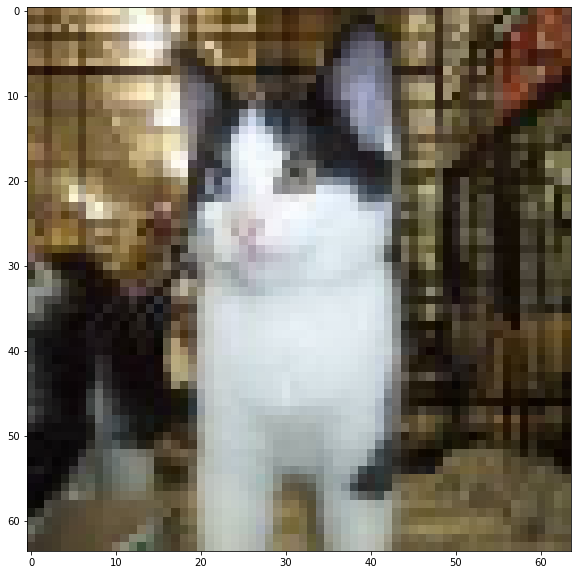

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


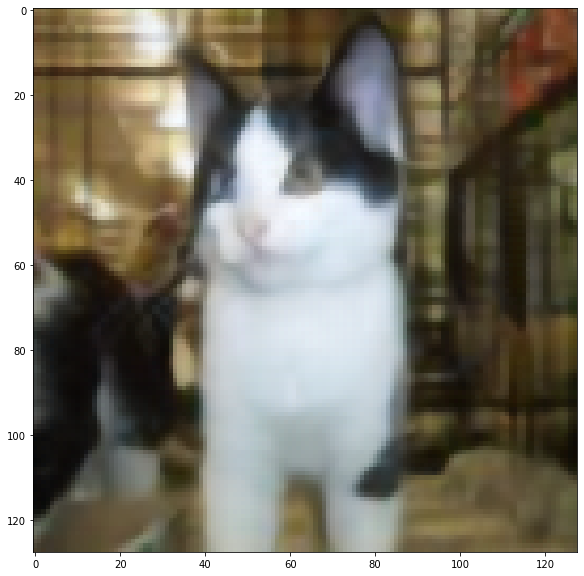

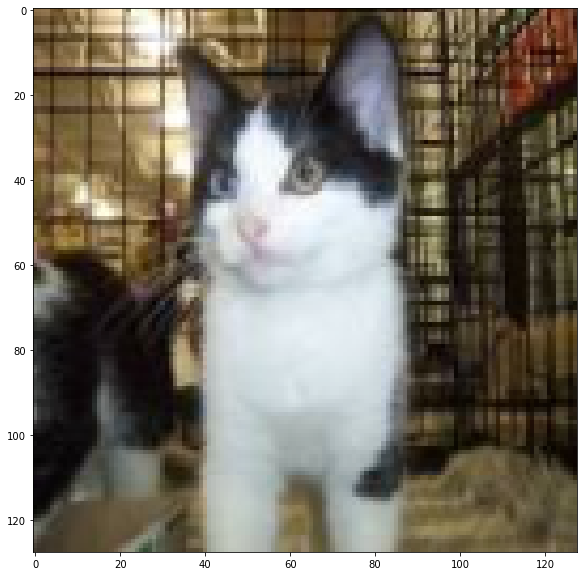

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(x[0], vmin=0, vmax=1)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(np.squeeze(pred).astype(np.float32), vmin=0, vmax=1)
plt.show()
plt.figure(figsize=(10,10))
plt.imshow(y[0], vmin=0, vmax=1)
plt.show()

*Save plot for milestone:*

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


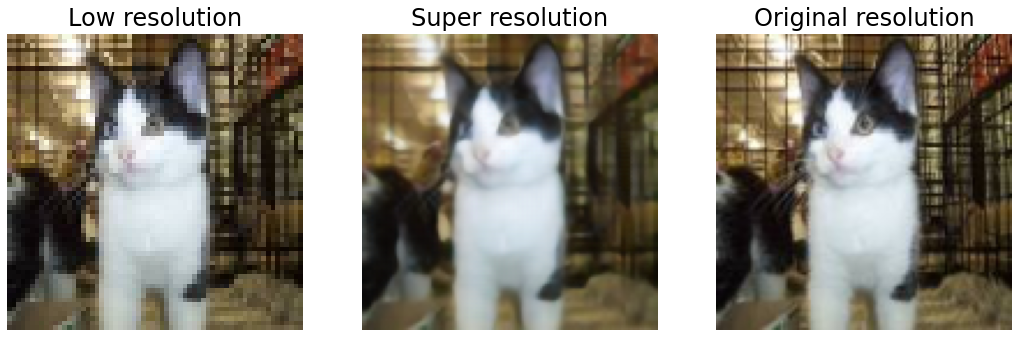

In [36]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(x[0], vmin=0, vmax=1)
axs[0].set_title('Low resolution', fontsize=24, y=1.01)
axs[1].imshow(np.squeeze(pred).astype(np.float32), vmin=0, vmax=1)
axs[1].set_title('Super resolution', fontsize=24, y=1.01)
axs[2].imshow(y[0], vmin=0, vmax=1)
axs[2].set_title('Original resolution', fontsize=24, y=1.01)

[ax.set_axis_off() for ax in axs.ravel()]
plt.show()
#plt.savefig('./plots/cats.pdf', bbox_inches='tight', format='pdf')